# Imports and hyperparameters

In [1]:
import copy
import wandb
import os

import lightning as l
import torch
import torchvision
import torchmetrics
from torch import nn
import matplotlib.pyplot as plt

from lightly.data import LightlyDataset
from lightly.loss.vicreg_loss import VICRegLoss
from lightly.models.modules.heads import VICRegProjectionHead
from lightly.transforms.vicreg_transform import VICRegTransform
from lightly.models.utils import (
    batch_shuffle,
    batch_unshuffle,
    deactivate_requires_grad,
    update_momentum,
)
from lightly.transforms import utils
from torch.optim import SGD, Adam

In [2]:
wandb.login()

wandb: Currently logged in as: czifrus-hanna (czhanna-wandb). Use `wandb login --relogin` to force relogin


True

In [3]:
num_workers = os.cpu_count()
batch_size = 512
memory_bank_size = 4096
seed = 1
max_epochs = 100
data_dir = '../data/'
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [4]:
path_to_train = data_dir + "100-bird-species/train/"
path_to_valid = data_dir + "100-bird-species/valid/"
path_to_test = data_dir + "100-bird-species/test/"

In [5]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(path_to_train)
num_classes = len(dataset.classes)
print(num_classes)

525


In [6]:
l.seed_everything(seed)

Seed set to 1


1

# Datasets

In [7]:
train_vicreg_transform = VICRegTransform(
    input_size=32,
    gaussian_blur=0.0,
)

train_classifier_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [8]:
dataset_train_vicreg = LightlyDataset(input_dir=path_to_train, transform=train_vicreg_transform)

dataset_train_classifier = LightlyDataset(
    input_dir=path_to_train, transform=train_classifier_transforms
)

dataset_valid = LightlyDataset(input_dir=path_to_valid, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

In [9]:
dataloader_train_vicreg = torch.utils.data.DataLoader(
    dataset_train_vicreg,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_train_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

# VICReg class 
SSL-method with pretrained resnet18 backbone

In [10]:
class VICReg(l.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = VICRegProjectionHead(
            input_dim=512,
            hidden_dim=2048,
            output_dim=2048,
            num_layers=4,
        )
        self.criterion = VICRegLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("vicreg_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optim = Adam(self.parameters(), lr=0.06)
        return optim

# Classifier class
Defining one classification layer after the backbone

In [11]:
class Classifier(l.LightningModule):
    def __init__(self, backbone, freeze, num_classes):
        super().__init__()
        self.backbone = backbone

        if freeze:
            # freeze the backbone
            deactivate_requires_grad(backbone)

        # create a linear layer for our downstream classification model
        self.fc = nn.Linear(512, num_classes)

        self.firstTime = True

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.validation_step_outputs = []

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        if self.firstTime:
            self.firstTime = False
            print(type(x))
            print(x)
            print(type(y))
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("classifier_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)

        _, predicted = torch.max(y_hat, 1)
        num = predicted.shape[0]
        correct = (predicted == y).float().sum()
        self.validation_step_outputs.append((num, correct))
        return num, correct

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            total_num = 0
            total_correct = 0
            for num, correct in self.validation_step_outputs:
                total_num += num
                total_correct += correct
            acc = total_correct / total_num
            self.log("val_acc", acc, on_epoch=True, prog_bar=True)
            self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        return (y_hat, y)

    def configure_optimizers(self):
        optim = Adam(self.fc.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

# Training

You can load the trained models after each training cell by specifying the appropriate path and commenting out the required lines

## VICReg training

In [36]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="VICReg", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='vicreg_loss',
    mode='min',
    dirpath = './models/',
    filename = 'best_model_vicreg',
)

ssl_model = VICReg()
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)
trainer.fit(model=ssl_model, train_dataloaders=dataloader_train_vicreg)

wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | VICRegProjectionHead | 13.6 M
2 | criterion       | VICRegLoss           | 0     
---------------------------------------------------------
24.8 M    Trainable params
0         Non-trainable params
24.8 M    Total params
99.289    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/165 [00:00<?, ?it/s] 

C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 99: 100%|██████████| 165/165 [00:08<00:00, 19.81it/s, v_num=dae3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 165/165 [00:09<00:00, 17.58it/s, v_num=dae3]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
vicreg_loss_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
vicreg_loss_step,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
trainer/global_step,16499
vicreg_loss_epoch,22.60699
vicreg_loss_step,22.49124


In [12]:
# Before running change ckpt_path to the correct one
# ckpt_path = "models/best_model_vicreg.ckpt"

# ssl_model = VICReg()
# ssl_model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict'])

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for VICReg:
	Missing key(s) in state_dict: "projection_head.layers.4.weight", "projection_head.layers.4.bias", "projection_head.layers.4.running_mean", "projection_head.layers.4.running_var", "projection_head.layers.6.weight", "projection_head.layers.7.weight", "projection_head.layers.7.bias", "projection_head.layers.7.running_mean", "projection_head.layers.7.running_var", "projection_head.layers.9.weight", "projection_head.layers.9.bias". 
	Unexpected key(s) in state_dict: "projection_head.layers.3.bias". 

## Classifier training

In [16]:
def train_classifier(wandb_name, filename, backbone, freeze, max_eps):
    wandb_logger = l.pytorch.loggers.WandbLogger(
        name=wandb_name, project="Self-supervised learning in-the-wild"
    )
    callback = l.pytorch.callbacks.ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        dirpath = './models/',
        filename = filename,
    )

    classifier = Classifier(backbone, freeze, num_classes)
    trainer = l.pytorch.Trainer(
        max_epochs=max_eps, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]

    )
    trainer.fit(classifier, dataloader_train_classifier, dataloader_valid)

    wandb.finish()
    
    return classifier

### With ssl pretrained backbone and frozen weights

In [44]:
model_ssl_frozen = train_classifier("Classifier ssl frozen backbone", 
                                    'best_model_with_ssl_frozen', 
                                    ssl_model.backbone, True, max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\loggers\wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 11.2 M
1 | fc        | Linear             | 269 K 
2 | cri

Sanity Checking: |          | 0/? [00:00<?, ?it/s]Epoch 0:   0%|          | 0/165 [00:00<?, ?it/s]                            <class 'torch.Tensor'>
tensor([[[[ 1.7009,  1.6495,  1.5639,  ...,  1.8722,  1.8208,  1.9235],
          [ 1.6838,  1.7009,  1.6495,  ...,  1.9578,  1.8893,  1.8550],
          [ 1.7865,  1.7009,  1.5810,  ...,  1.8037,  1.8722,  1.9064],
          ...,
          [ 0.5878,  0.4166,  0.8961,  ...,  1.5810,  1.6667,  1.6495],
          [ 0.8961,  0.6049,  0.4166,  ...,  1.5468,  1.6667,  1.7180],
          [ 0.8276,  0.4851,  0.8789,  ...,  1.6153,  1.6153,  1.6667]],

         [[ 1.6933,  1.6583,  1.5707,  ...,  2.0259,  2.0084,  2.1134],
          [ 1.6232,  1.6583,  1.6057,  ...,  2.0784,  2.0084,  2.0084],
          [ 1.7458,  1.6583,  1.5357,  ...,  1.8508,  1.9559,  2.0259],
          ...,
          [-0.5126, -0.7052, -0.1975,  ...,  1.7283,  1.8158,  1.7983],
          [-0.2675, -0.5301, -0.6527,  ...,  1.7108,  1.8333,  1.8683],
          [-0.3375, -0.6176

C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


classifier_loss,▃▆▃▅▄█▆▃▇▂▅▇▃▂▁▄▅▄▅▃▃▄▄▅▅▄▃▃▃▇▅▆▇▄▂▃▂▃▃▃
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,█▂▂▄▂▂▁▂▂▁▁▃▁▅▄▂▂▄
classifier_loss,9.22698
epoch,16
trainer/global_step,2804
val_acc,0.00419


In [39]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

# ckpt_with_classifier_path = "models/best_model_with_ssl_frozen.ckpt"

# ssl_model = VICReg()
# model_ssl_frozen = Classifier(ssl_model.backbone, True, num_classes)
# model_ssl_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

### With ssl pretrained backbone and NOT frozen weights

In [ ]:
model_ssl_not_frozen = train_classifier("Classifier ssl not frozen backbone",
                                        'best_model_with_ssl_not_frozen',
                                        ssl_model.backbone, False, max_epochs)

In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

# ckpt_with_classifier_path = "models/best_model_with_ssl_not_frozen.ckpt"

# ssl_model = VICReg()
# model_ssl_not_frozen = Classifier(ssl_model.backbone, False, num_classes)
# model_ssl_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

### Without SSL, but pretrained backbone with frozen weights

In [ ]:
# Defining the pretrained backbone
# Running this cell is also required for loading from checkpoint

resnet_pt = torchvision.models.resnet18(pretrained=True)
backbone_pt = nn.Sequential(*list(resnet_pt.children())[:-1])

In [17]:
model_pretrained_frozen = train_classifier("Classifier pretrained and frozen backbone",
                                           'best_model_with_pretrained_frozen',
                                           backbone_pt, True, max_epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory ./models/ exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 11.2 M
1 | fc        | Linear             | 269 K 
2 | criterion | CrossEntropyLoss   | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

<class 'torch.Tensor'>
tensor([[[[ 0.3138,  0.3138,  0.3138,  ...,  0.2111,  0.2111,  0.2624],
          [ 0.3481,  0.3309,  0.2796,  ...,  0.2453,  0.2453,  0.2796],
          [ 0.3481,  0.3309,  0.2796,  ...,  0.3309,  0.3309,  0.3652],
          ...,
          [ 0.0741,  0.1254,  0.1768,  ...,  0.2453,  0.2967,  0.2453],
          [ 0.0398,  0.0569,  0.1083,  ...,  0.1254,  0.1939,  0.1426],
          [ 0.0398,  0.0741,  0.1254,  ...,  0.1083,  0.1768,  0.1426]],

         [[ 0.3277,  0.3277,  0.3277,  ...,  0.2227,  0.2227,  0.2402],
          [ 0.3627,  0.3452,  0.2927,  ...,  0.2577,  0.2577,  0.2577],
          [ 0.3627,  0.3452,  0.2927,  ...,  0.3452,  0.3452,  0.3452],
          ...,
          [ 0.0476,  0.1001,  0.1527,  ...,  0.3102,  0.3627,  0.2752],
          [-0.0224,  0.0301,  0.0826,  ...,  0.1877,  0.2577,  0.1702],
          [-0.0224,  0.0476,  0.1001,  ...,  0.1702,  0.2402,  0.1702]],

         [[ 0.4091,  0.4091,  0.4091,  ...,  0.2696,  0.2696,  0.3045],
       

C:\Users\Hanna\anaconda3\envs\deep_learning\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


classifier_loss,█▁
epoch,▁▁
trainer/global_step,▁█
classifier_loss,7.04107
epoch,0
trainer/global_step,99


In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_pt
# and comment out the lines below.

# ckpt_with_classifier_path = "models/best_model_with_pretrained_frozen.ckpt"

# model_pretrained_frozen = Classifier(backbone_pt, False, num_classes)
# model_pretrained_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

### Without SSL, but pretrained backbone with NOT frozen weights

In [14]:
model_pretrained_not_frozen = train_classifier("Classifier pretrained and not frozen backbone",
                                               'best_model_with_pretrained_not_frozen',
                                               backbone_pt, False, max_epochs)

NameError: name 'backbone' is not defined

In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 4 up that defines the backbone_pt
# and comment out the lines below.

# ckpt_with_classifier_path = "models/best_model_with_pretrained_not_frozen.ckpt"

# model_pretrained_not_frozen = Classifier(backbone_pt, False, num_classes)
# model_pretrained_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

### With untrained backbone

In [ ]:
# Defining the untrained backbone
# Running this cell is also required for loading from checkpoint

resnet_npt = torchvision.models.resnet18(pretrained=False)
backbone_npt = nn.Sequential(*list(resnet_npt.children())[:-1])

In [ ]:
model_untrained = train_classifier("Classifier untrained backbone",
                                   'best_model_with_untrained',
                                   backbone_npt, False, max_epochs)

In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_npt
# and comment out the lines below.

# ckpt_with_classifier_path = "models/best_model_with_untrained.ckpt"

# model_untrained = Classifier(backbone_npt, False, num_classes)
# model_untrained.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

# Evaluation

## Accuracy on test dataset

In [40]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="Classifier", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='val_acc',
    mode='max'
)
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)

model_ssl_frozen.eval()
trainer.validate(model_ssl_frozen, dataloader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 164.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.008380952291190624    │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.008380952291190624}]

## Confusion matrix

In [41]:
def evaluate_model(model, dataloader, num_classes):
    confusion_matrix_metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
    model.eval()
    with torch.no_grad():
        for y_hat, y in trainer.predict(model, dataloader):
            confusion_matrix_metric(y_hat.softmax(dim=-1), y)
    confusion_matrix = confusion_matrix_metric.compute()
    return confusion_matrix

confusion_matrix = evaluate_model(model_ssl_frozen, dataloader_test, num_classes)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 157.91it/s]


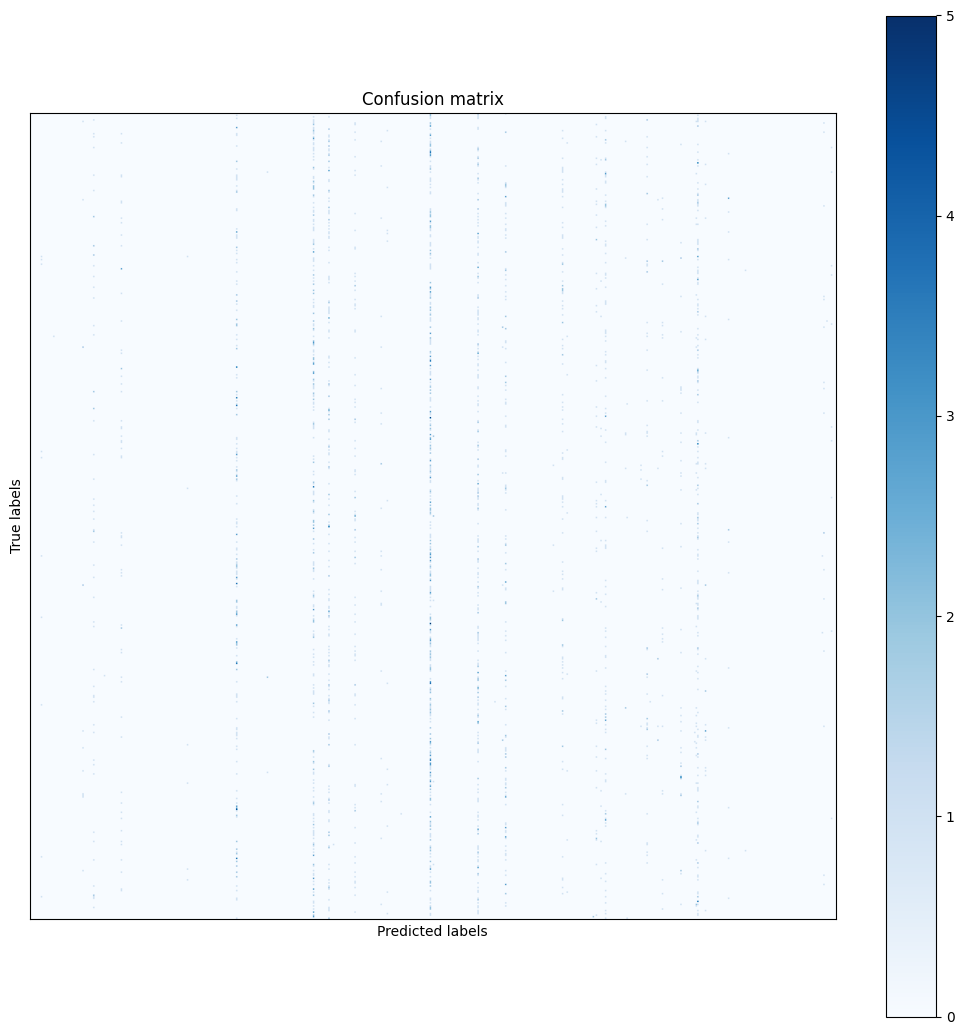

In [42]:
plt.figure(figsize=(13,13))
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix')
plt.colorbar()
plt.show()
plt.close()